# Classification. Linear models and KNN

In [49]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [50]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.metrics import plot_confusion_matrix, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression


In [51]:
PATH = "./data/"

## Part 2: Porto Seguro’s Safe Driver Prediction

Let's build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year.
Read the detailed description and download the dataset https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data. Put the data into *./data/porto/*.

In [52]:
insurance_data = pd.read_csv(os.path.join(PATH, 'porto', 'train.csv')).set_index('id')

In [53]:
insurance_data.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
7,0,2,2,5,1,0,0,1,0,0,...,9,1,5,8,0,1,1,0,0,1
9,0,1,1,7,0,0,0,0,1,0,...,3,1,1,9,0,1,1,0,1,0
13,0,5,4,9,1,0,0,0,1,0,...,4,2,7,7,0,1,1,0,1,0
16,0,0,1,2,0,0,1,0,0,0,...,2,2,4,9,0,0,0,0,0,0
17,0,0,2,0,1,0,1,0,0,0,...,3,1,1,3,0,0,0,1,1,0


Let's skip EDA for now. We'll use SGDClassifier and build a simple baseline: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html.
Note that loss='log' gives logistic regression.

In [54]:
y = insurance_data['target']
X = insurance_data.drop(columns=['target'])

In [55]:
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SGDClassifier(loss='log', alpha=0.001, n_jobs=-1, random_state=14))])

In [56]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [57]:
clf = pipeline.fit(X_train, y_train)

We'll calculate the model accuracy:

In [58]:
accuracy_score(y_true=y_valid, y_pred=clf.predict(X_valid))

0.9631224658945812

Wow! Our model gets ~0.963 accuracy! But is it really good?...

Let's plot the confusion matrix and analyze the errors.

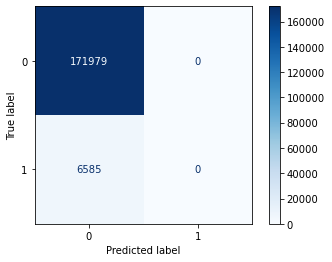

In [59]:
disp = plot_confusion_matrix(clf, X_valid, y_valid,
                             cmap=plt.cm.Blues,
                             normalize=None)

Well, it turns out that our model is completely useless. Let's calculate some basic statistics:

In [60]:
insurance_data.describe()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,...,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,1.900378,1.358943,4.423318,0.416794,0.405188,0.393742,0.257033,0.163921,0.185304,...,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,1.983789,0.664594,2.699902,0.493311,1.350642,0.488579,0.436998,0.370205,0.388544,...,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,1.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,3.000000,2.000000,6.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,7.000000,2.000000,4.000000,9.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,7.000000,4.000000,11.000000,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,...,19.000000,10.000000,13.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


As you see, there are less than 4% of positive examples, so we have to deal with a highly imbalanced dataset.

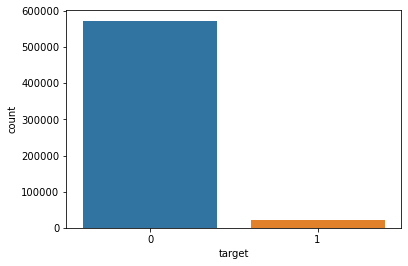

In [61]:
sns.countplot(x='target', data=insurance_data)
plt.show()

In [62]:
y.value_counts()

0    573518
1     21694
Name: target, dtype: int64

Accuracy is not informative here and the Normalized Gini Coefficient will be used instead: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/overview/evaluation.

In [63]:
# Code for calculating Normalized gini coefficient
# https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703
def gini(actual, pred, cmpcol = 0, sortcol = 1):  
    assert(len(actual) == len(pred))  
    epsilon = 1e-7
    values = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)  
    values = values[np.lexsort((values[:, 2], -1 * values[:, 1]))]  
    total = values[:, 0].sum() 
    gini_sum = (values[:, 0].cumsum().sum() + epsilon) / (total + epsilon)  
  
    gini_sum -= (len(actual) + 1) / 2  
    return gini_sum / len(actual)  
  
def gini_normalized(a, p):  
    '''Function to calculate the normalized gini coefficient'''
    return gini(a, p) / gini(a, a)

**(1.5 points)** Prove that the **Normalized Gini Coefficient** is equivalent to **2 x AUC - 1** :

PLease check Gini.jpg in repository

Based on https://towardsdatascience.com/using-the-gini-coefficient-to-evaluate-the-performance-of-credit-score-models-59fe13ef420

<img src="files/Gini.jpg" width="700">

**(0.5 points)** By the way, what other metrics could you suggest for this problem?

As seen from the confusion matrix above, values TP, TN, FP, FN are important for imbalanced data. Therefore, metric must be used that takes into account the relationship between these quantities. Such metric is f1_score, which combines recall metric and precision metric. f1 = $\frac{2TP}{2TP+FP+FN}$

Let's calculate the Normalized Gini Coefficient:

In [64]:
y_pred = clf.predict_proba(X_valid)[:, 1]

In [65]:
gini_normalized(y_valid, y_pred)

0.2558723581569817

**(0.5 points + Y bonus points)** Try different approaches: oversampling / undersampling, careful feature analysis and feature engineering, etc., to get a reasonable pipeline and improve the model quality. Use cross-validation for model evaluation.

Select the best model, load the test set and make the predictions. Submit them to kaggle.
Y bonus points will be calculated as $\frac{round(200 * \max(score - 0.253, 0))}{2}$, where *score* is your kaggle leaderboard score.

Note: do not use any classification models which have not been covered in the lessons yet.

In [66]:
data_train = pd.read_csv(os.path.join(PATH, 'porto', 'train.csv')).set_index('id')
data_test = pd.read_csv(os.path.join(PATH, 'porto', 'test.csv')).set_index('id')

In [67]:
df_train = data_train.copy()
df_test = data_test.copy()
df_whole = pd.concat([df_train,df_test])

In [68]:
df_whole

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
7,0.0,2,2,5,1,0,0,1,0,0,...,9,1,5,8,0,1,1,0,0,1
9,0.0,1,1,7,0,0,0,0,1,0,...,3,1,1,9,0,1,1,0,1,0
13,0.0,5,4,9,1,0,0,0,1,0,...,4,2,7,7,0,1,1,0,1,0
16,0.0,0,1,2,0,0,1,0,0,0,...,2,2,4,9,0,0,0,0,0,0
17,0.0,0,2,0,1,0,1,0,0,0,...,3,1,1,3,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1488022,NaN,0,1,6,0,0,0,1,0,0,...,4,2,3,4,0,1,0,0,1,0
1488023,NaN,5,3,5,1,0,0,0,1,0,...,6,2,2,11,0,0,1,1,0,0
1488024,NaN,0,1,5,0,0,1,0,0,0,...,5,2,2,11,0,1,1,0,0,0


-1 means nan in this case...so put nan back

In [69]:
df_whole = df_whole.replace(-1, np.NaN)

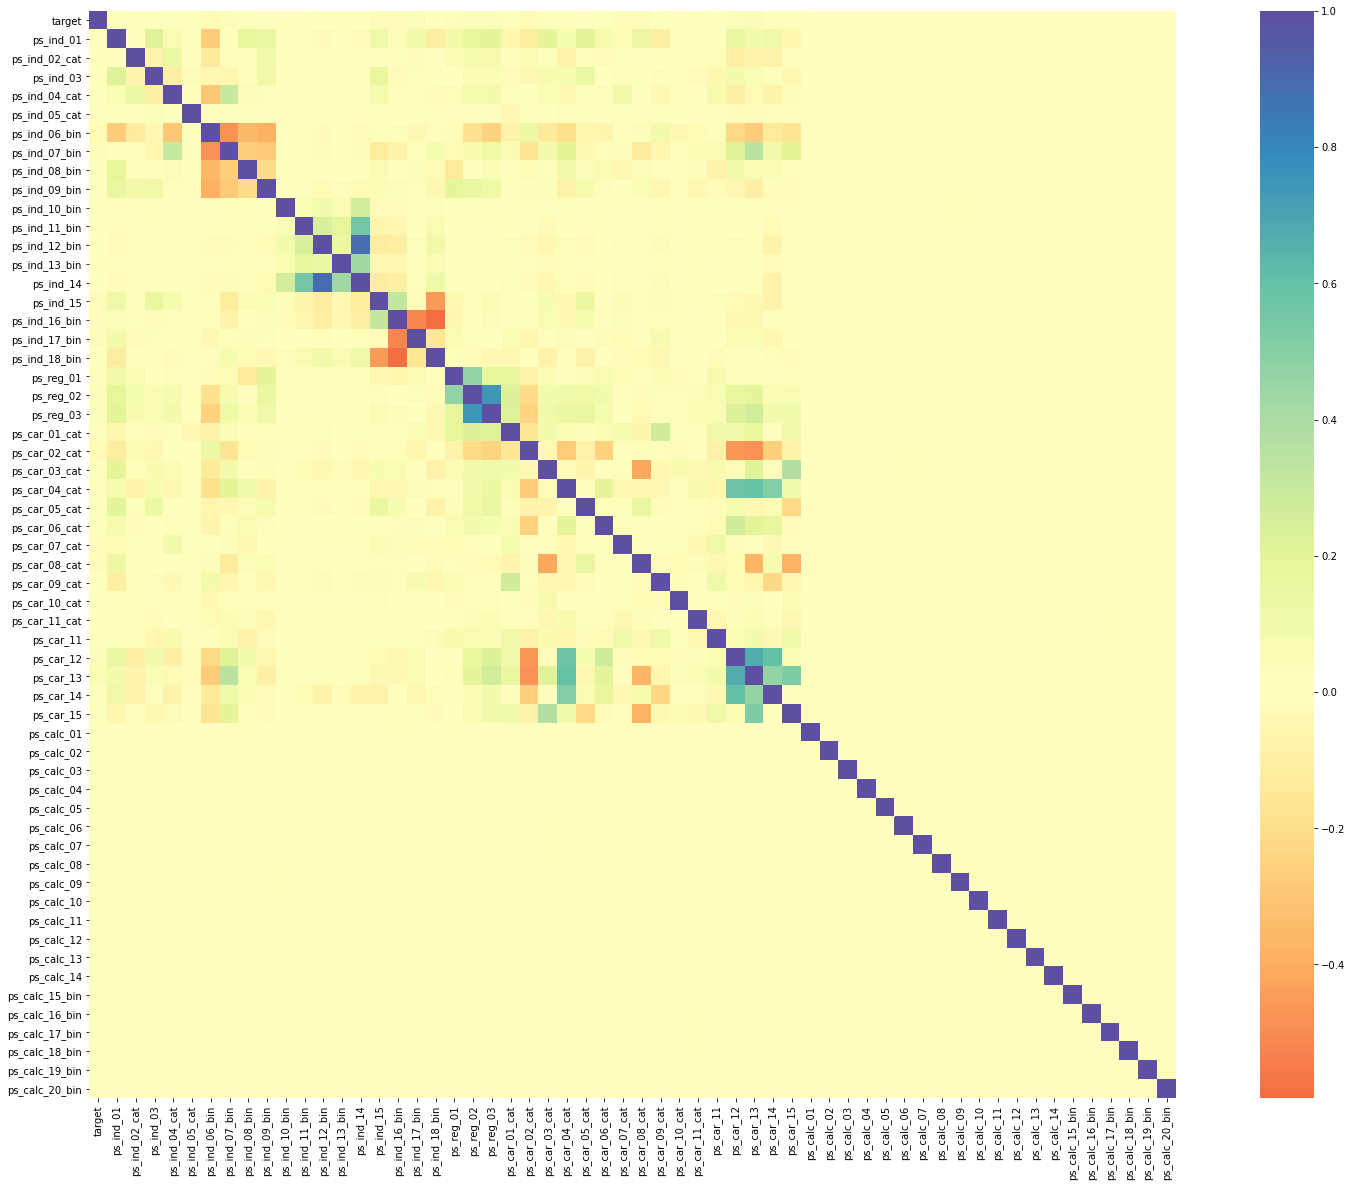

In [70]:
plt.figure(figsize=(30,20))
sns.heatmap(df_whole.corr(method='pearson'), center=0, square=True, cmap='Spectral')
plt.show()

Features, that contain _calc_ in nams do not correlate with other feature, so drop them out.

In [71]:
calc_col = [col for col in df_whole.columns if '_calc' in col]
df_whole = df_whole.drop(calc_col, axis=1)

In [72]:
#plt.figure(figsize=(30,20))
#sns.heatmap(X.corr(method='pearson'), center=0, square=True, cmap='Spectral')
#plt.show()

Let's take alook at counts of 1 in binary features

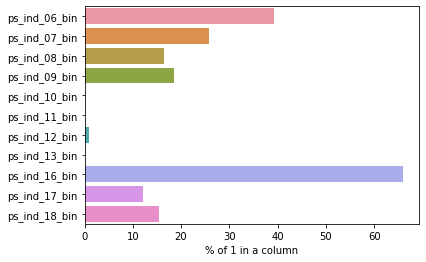

In [73]:
bin_col = [col for col in df_whole.columns if '_bin' in col]
counts = []
for col in bin_col:
    counts.append(100*(df_whole[col]==1).sum()/df_whole.shape[0])

ax = sns.barplot(x=counts, y=bin_col, orient='h')
ax.set(xlabel="% of 1 in a column")
plt.show()

"ps_ind_10_bin","ps_ind_11_bin","ps_ind_12_bin","ps_ind_13_bin" are useless, so drop them out

In [74]:
df_whole = df_whole.drop(["ps_ind_10_bin","ps_ind_11_bin","ps_ind_12_bin","ps_ind_13_bin"], axis=1)

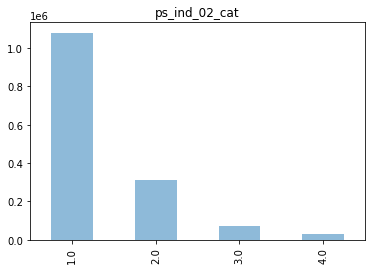

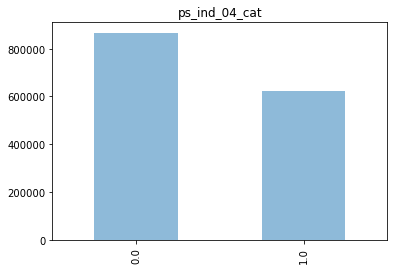

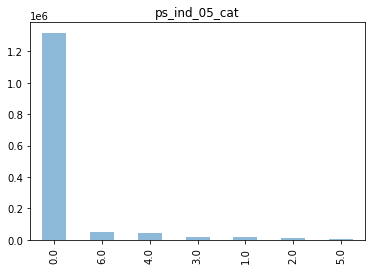

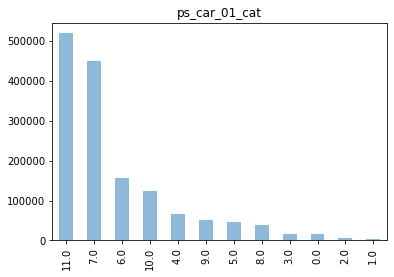

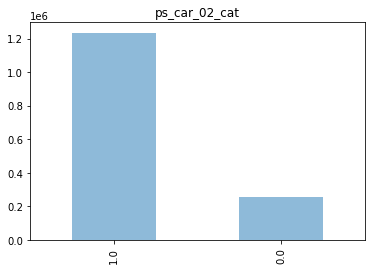

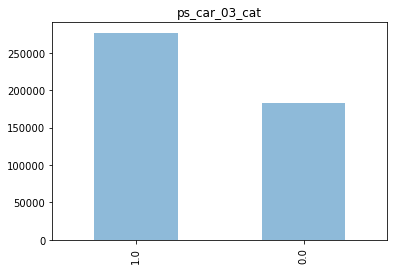

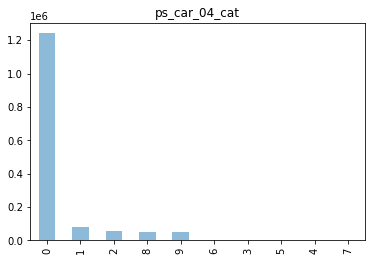

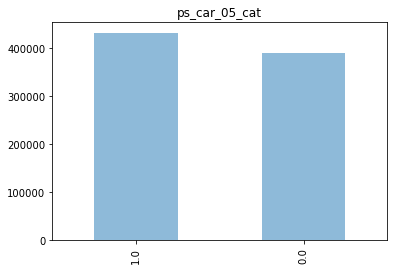

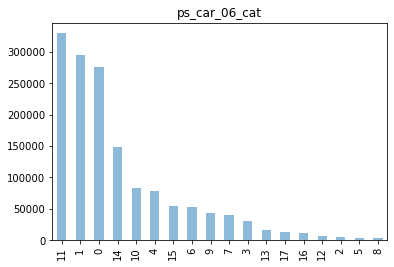

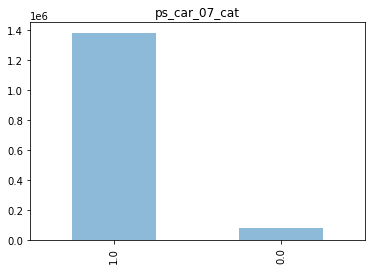

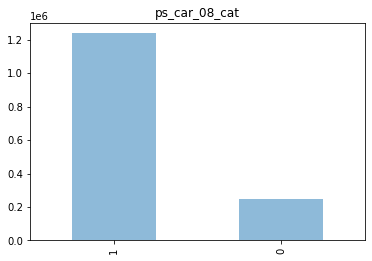

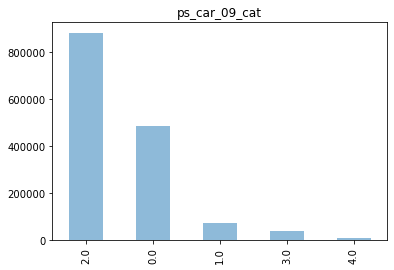

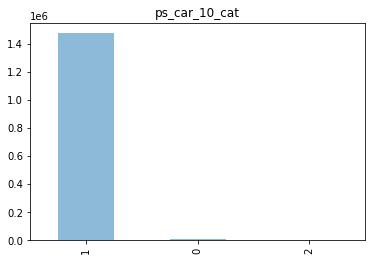

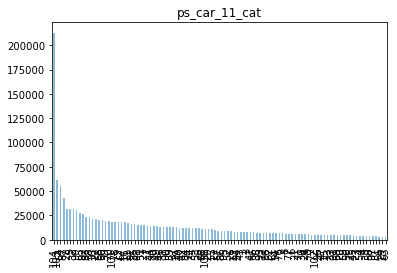

In [75]:
cat_col = [col for col in df_whole.columns if '_cat' in col]
counts = []
for col in cat_col:
    #print(col)
    df_whole[col].value_counts().plot(kind='bar',alpha=0.5)
    plt.title(col)
    plt.show()

'ps_car_10_cat' is useless

In [76]:
df_whole =df_whole.drop(['ps_car_10_cat'], axis=1)

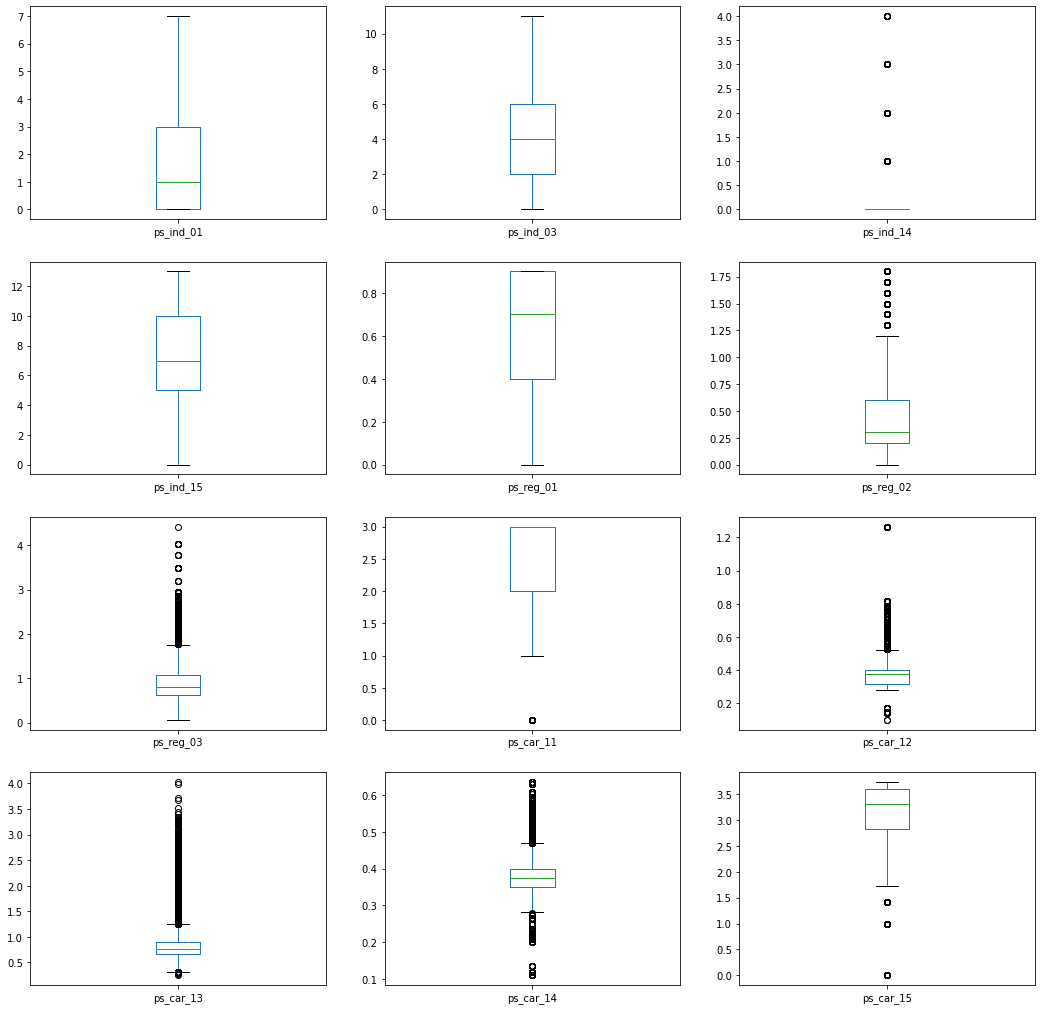

In [77]:
df_whole_feat_ = df_whole[['ps_ind_01', 'ps_ind_03', 'ps_ind_14', 'ps_ind_15', 
           'ps_reg_01', 'ps_reg_02', 'ps_reg_03', 
           'ps_car_11', 'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15']]

df_whole_feat_.plot(kind='box', subplots=True, layout=(4,3), sharey=False, figsize=(18,18))
plt.show()

In [78]:
# ps_car_13/ps_reg_03 имеют очень похожее распределение

ps_car_13/ps_reg_03 has very similar distribution, so let's create new feature based on them. Meanwhile 'ps_ind_14' is useless.

In [79]:
df_whole['car_13*reg_03'] = df_whole['ps_car_13']*df_whole['ps_reg_03']

In [80]:
df_whole =df_whole.drop(['ps_ind_14'], axis=1)

In [81]:
df_whole = df_whole.fillna(df_whole.median())

In [82]:
x = StandardScaler().fit_transform(df_whole.drop('target',axis=1))
x.shape

(1488028, 32)

In [83]:
df_whole_scaled = pd.DataFrame(data=x, columns = df_whole.columns[1:], index=df_whole.index)
df_whole_scaled

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_15,...,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,car_13*reg_03
id,,,,,,,,,,,,,,,,,,,,,
7,0.049575,0.967313,0.215712,1.181705,-0.30943,-0.805390,1.699741,-0.442532,-0.477488,1.044681,...,0.232220,-2.227139,-1.363578,-1.522602,-0.416360,0.343562,0.312374,-0.086103,0.737305,-0.232378
9,-0.454098,-0.542810,0.956438,-0.846235,-0.30943,-0.805390,-0.588325,2.259725,-0.477488,-1.212920,...,0.232220,0.449007,0.685040,-1.310527,0.785574,-1.092101,-0.866352,0.321220,-0.846447,-0.641192
13,1.560592,3.987559,1.697164,1.181705,-0.30943,-0.805390,-0.588325,2.259725,-0.477488,1.326881,...,0.232220,0.449007,0.685040,-0.068374,-1.618294,-1.092101,-0.765021,-0.621473,0.341489,-0.264795
16,-0.957771,-0.542810,-0.895378,-0.846235,-0.30943,1.241635,-0.588325,-0.442532,-0.477488,0.198080,...,0.232220,0.449007,1.709348,1.264668,-1.618294,-0.099177,-1.203989,-1.811589,-1.462228,-1.045305
17,-0.957771,0.967313,-1.636104,1.181705,-0.30943,1.241635,-0.588325,-0.442532,-0.477488,0.480280,...,0.232220,0.449007,0.685040,0.598147,0.785574,-1.094811,-1.102153,-0.215930,-1.462228,-0.636948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1488022,-0.957771,-0.542810,0.586075,-0.846235,-0.30943,-0.805390,1.699741,-0.442532,-0.477488,-1.495121,...,-4.306255,0.449007,-1.363578,-1.340824,-0.416360,3.183030,3.183259,4.346919,0.737305,2.235675
1488023,1.560592,2.477436,0.215712,1.181705,-0.30943,-0.805390,-0.588325,2.259725,-0.477488,1.044681,...,0.232220,-2.227139,-1.363578,0.628443,-0.416360,0.759393,1.010579,1.000319,0.923765,1.455328
1488024,-0.957771,-0.542810,0.215712,-0.846235,-0.30943,1.241635,-0.588325,-0.442532,-0.477488,-0.648520,...,0.232220,-2.227139,-0.339269,-1.371120,-0.416360,-0.099177,0.692047,0.359177,0.923765,-0.344805


In [84]:
X_train_ = df_whole_scaled[:df_train.shape[0]]
y_train_ = df_train['target']
X_test_  = df_whole_scaled[df_train.shape[0]:]
print('X_train shape', X_train_.shape)
print('y_train shape', y_train_.shape)
print('X_test shape', X_test_.shape)

X_train shape (595212, 32)
y_train shape (595212,)
X_test shape (892816, 32)


In [85]:
X_train, X_test, y_train, y_test = train_test_split(X_train_, y_train_, test_size=0.3, random_state=42)
print('X_train shape', X_train.shape)
print('y_train shape', y_train.shape)
print('X_test shape', X_test.shape)
print('y_test shape', y_test.shape)

X_train shape (416648, 32)
y_train shape (416648,)
X_test shape (178564, 32)
y_test shape (178564,)


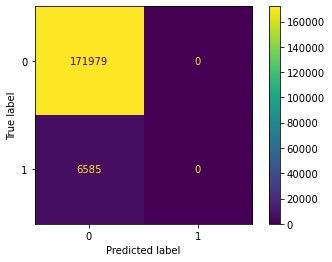

In [86]:
lr = LogisticRegression(solver = 'newton-cg', max_iter=2000)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()

One of the ways to deal with imbalanced data is to assign weights to the classes(https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/)

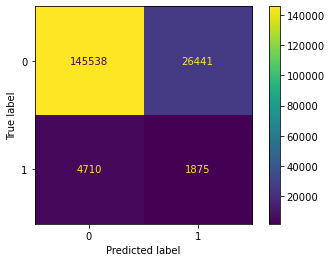

In [87]:
lr = LogisticRegression(solver = 'newton-cg', class_weight={0: 0.05, 1: 0.95}, max_iter=2000)
lr.fit(X_train, y_train)

y_pred_weighted = lr.predict(X_test)
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_weighted)).plot()

Computing power of my computer is not enough to process this data. It also turned out in the end that we need to count the probabilities... 
So my kaggle score = 0 :D